In [ ]:
import pandas as pd
import os
import numpy as np

In [ ]:
X = pd.read_csv('/content/drive/MyDrive/OS2931.csv',encoding="ISO-8859-1")

In [ ]:
print(X)

      ï»¿iD                                           Response  Reviewer-1  \
0         1  An operating system (OS) is system software th...           4   
1         1  An operating system is the most important soft...           5   
2         1  Collection of programs that manages hardware r...           2   
3         1      It is an interface user and machine(hardware)           2   
4         1  An operating system is a software which acts a...           3   
...     ...                                                ...         ...   
2385      5  Single processor contains only one processer.w...           2   
2386      5  Single processor systems are less reliable tha...           3   
2387      5  Single processor system contains only one proc...           2   
2388      5  Single processor can assign only one task but ...           1   
2389      5  Single Processor\n-> Uses a single cpu\n-> Eas...           2   

      Reviewer-2  
0              4  
1              5  
2     

In [ ]:
X=X[X['ï»¿iD']==3]
X = X.dropna(axis=1)
y = X['Reviewer-1']
print(y)

1112    3
1113    3
1114    3
1115    2
1116    1
       ..
1419    2
1420    1
1421    3
1422    3
1423    1
Name: Reviewer-1, Length: 312, dtype: int64


In [ ]:
from keras.layers import Embedding, LSTM, Dense, Dropout, Lambda, Flatten
from keras.models import Sequential, load_model, model_from_config
import keras.backend as K

def get_model():
    """Define the model."""
    model = Sequential()
    model.add(LSTM(300,dropout=0.5,recurrent_dropout=0.4, input_shape=[1, 2944], return_sequences=True))
    #model.add(LSTM(300, dropout=0.5, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(200, dropout=0.5, recurrent_dropout=0.4, return_sequences=True))
    model.add(LSTM(100, return_sequences=True))
    model.add(LSTM(64, recurrent_dropout=0.4))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='relu'))
    model.compile(loss='mean_squared_error', optimizer=tf.optimizers.Adam(lr=0.001),metrics=['accuracy'])
    #model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['accuracy'])
    model.summary()

    return model

In [ ]:
import tensorflow_hub as hub

use = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")
aa=[]

In [ ]:
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from nltk.tokenize import PunktSentenceTokenizer
from nltk.tokenize import sent_tokenize
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
def essay_to_sentences(essay_v, remove_stopwords):
    """Sentence tokenize the essay and call essay_to_wordlist() for word tokenization."""
    tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
    #tokennizer=PunktSentenceTokenizer(english.pickle)
    raw_sentences = tokenizer.tokenize(essay_v.strip())
    sentences = []
    for raw_sentence in raw_sentences:
        if len(raw_sentence) > 0:
            sentences.append((raw_sentence))
    #print(sentences)
    return sentences

def makeFeatureVec(words, num_features,n):
    """Make Feature Vector from the words list of an Essay."""
    featureVec = np.zeros((n,num_features),dtype="float32")
    #success
    x=use(words) #length of feature vector is (16,512) and length of use is (16,128)
    y=len(x[0])
#     featureVec = np.zeros((n,num_features),dtype="float32")
    featureVec = np.zeros((n,y),dtype="float32")
    featureVec = np.add(featureVec,x).flatten() # getting error while adding vectors
    ss=num_features-y
#     print("diff=",ss)
    featureVec = np.pad(featureVec, (0,ss), 'constant', constant_values=(0, 0))
#     print("AFTER PADDING",featureVec,len(featureVec))
#     print("SHAPE",featureVec.shape)     
    #featureVec = np.divide(featureVec,num_words)
    return featureVec

def getAvgFeatureVecs(essays, num_features,aa):
    """Main function to generate the word vectors for word2vec model."""
    counter = 0
    essayFeatureVecs = np.zeros((len(essays),num_features*23),dtype="float32") # creating max length feature vector having 0s
#     print(num_features*96)
    for essay in essays:
        
#         #essayFeatureVecs.insert(counter,makeFeatureVec(essay,num_features,aa[counter]))
        arr=makeFeatureVec(essay, num_features,aa[counter]).flatten() # getting error here
#         print(arr)
        ss=(num_features*23)-len(arr)
        arr1=np.pad(arr,(0,ss),'constant', constant_values=(0, 0))
#         #print(np.add(arr1,np.zeros(num_features*np.max(aa))))
        essayFeatureVecs[counter] = np.add(arr1,np.zeros((num_features*23),dtype="float"))
#         #makeFeatureVec(essay, num_features,aa[counter]).flatten()
#         #print(essayFeatureVecs[0])
        counter = counter + 1
    return essayFeatureVecs

In [ ]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score
import tensorflow as tf

cv = KFold(n_splits = 5, shuffle = True)
results = []
y_pred_list = []

count = 1
for traincv, testcv in cv.split(X):
    print("\n--------Fold {}--------\n".format(count))
    X_test, X_train, y_test, y_train = X.iloc[testcv], X.iloc[traincv], y.iloc[testcv], y.iloc[traincv]
    #print(X_train.isna())
    train_essays = X_train['Response']
    test_essays = X_test['Response']
    y_train=y_train
    y_test=y_test
    num_features = 128
    min_word_count = 40
    num_workers = 4
    context = 10
    downsampling = 1e-3
    clean_train_essays = []
    clean_test_essays=[]
    #essays=train_essays
    sentences=[]
    l1=[]
    l2=[]
    for essay in train_essays:
      sentences += essay_to_sentences(essay, remove_stopwords = False)
  
      #print(sentences)
    for essay in test_essays:
      sentences += essay_to_sentences(essay, remove_stopwords = False)

    for essay_v in train_essays:
      l1.append(len(sent_tokenize(essay_v)))
      clean_train_essays.append(essay_to_sentences(essay_v, remove_stopwords=True))
      #print(clean_train_essays)
    a=np.array(l1)
    print(np.max(a))
    trainDataVecs = getAvgFeatureVecs(clean_train_essays, num_features,a)
    for essay_v in test_essays:
      l2.append(len(sent_tokenize(essay_v)))
      clean_test_essays.append(essay_to_sentences(essay_v, remove_stopwords=True))
    b=np.array(l2)
    testDataVecs=getAvgFeatureVecs(clean_test_essays, num_features,b)
    trainDataVecs=np.array(trainDataVecs)
    testDataVecs = np.array(testDataVecs)
    trainDataVecs=np.reshape(trainDataVecs,(trainDataVecs.shape[0],1,trainDataVecs.shape[1]))
    testDataVecs = np.reshape(testDataVecs, (testDataVecs.shape[0], 1, testDataVecs.shape[1]))
    print(b)
    #print(y_train)
    X_train, X_val, y_train, y_val = train_test_split(trainDataVecs, y_train, test_size=0.2, random_state=3)
    lstm_model = get_model()
    history=lstm_model.fit(X_train, y_train, batch_size=16, epochs=50,validation_data=(X_val, y_val))
    
    #history=lstm_model.fit(trainDataVecs, y_train, batch_size=64, epochs=30)
    y_pred=(lstm_model.predict(testDataVecs))
    #print(testDataVecs)
    # Save any one of the 5 models.
    if count == 6:
      break
         #lstm_model.save('./model_weights/final_lstm.h5')
    
    # Round y_pred to the nearest integer.
    y_pred = np.around(y_pred)
    #print(y_pred)
    
    # Evaluate the model on the evaluation metric. "Quadratic mean averaged Kappa"
    result = cohen_kappa_score(y_test,y_pred,weights='quadratic')
    print("Kappa Score: {}".format(result))
    results.append(result)
    
    count += 1
   


--------Fold 1--------

18
[ 2  2  1  1  1  1  1  1  1  1  2  3  1  1  2  1  1  2  2  1  1  1  2  4
  1  1  1  1  9  1  1  1  1  2  2  2  1 12  2  1  1  1  1  2  4  2  4  2
  4  2  2  1  1  3  3  1  1  1  1  1  3 16  1]
Model: "sequential_65"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_150 (LSTM)             (None, 1, 300)            3894000   
                                                                 
 lstm_151 (LSTM)             (None, 1, 200)            400800    
                                                                 
 lstm_152 (LSTM)             (None, 1, 100)            120400    
                                                                 
 lstm_153 (LSTM)             (None, 64)                42240     
                                                                 
 dropout_65 (Dropout)        (None, 64)                0         
                              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


13/13 [==============================] - 13s 181ms/step - loss: 4.2206 - accuracy: 0.0553 - val_loss: 4.3797 - val_accuracy: 0.0000e+00
Epoch 2/50
13/13 [==============================] - 1s 70ms/step - loss: 2.3628 - accuracy: 0.2060 - val_loss: 0.6053 - val_accuracy: 0.3200
Epoch 3/50
13/13 [==============================] - 1s 70ms/step - loss: 0.8455 - accuracy: 0.3367 - val_loss: 0.6041 - val_accuracy: 0.3400
Epoch 4/50
13/13 [==============================] - 1s 68ms/step - loss: 0.5971 - accuracy: 0.3367 - val_loss: 0.4268 - val_accuracy: 0.3400
Epoch 5/50
13/13 [==============================] - 1s 70ms/step - loss: 0.5080 - accuracy: 0.3317 - val_loss: 0.3881 - val_accuracy: 0.3400
Epoch 6/50
13/13 [==============================] - 1s 70ms/step - loss: 0.4321 - accuracy: 0.3367 - val_loss: 0.3685 - val_accuracy: 0.3400
Epoch 7/50
13/13 [==============================] - 1s 70ms/step - loss: 0.4269 - accuracy: 0.3417 - val_loss: 0.3531 - val_accuracy: 0.3400
Epoch 8/50
13/13 [

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


13/13 [==============================] - 13s 181ms/step - loss: 4.1804 - accuracy: 0.0251 - val_loss: 4.2691 - val_accuracy: 0.0400
Epoch 2/50
13/13 [==============================] - 1s 69ms/step - loss: 2.3277 - accuracy: 0.1457 - val_loss: 0.5946 - val_accuracy: 0.3200
Epoch 3/50
13/13 [==============================] - 1s 67ms/step - loss: 0.8281 - accuracy: 0.3819 - val_loss: 0.6863 - val_accuracy: 0.3200
Epoch 4/50
13/13 [==============================] - 1s 68ms/step - loss: 0.6642 - accuracy: 0.3769 - val_loss: 0.4968 - val_accuracy: 0.3400
Epoch 5/50
13/13 [==============================] - 1s 70ms/step - loss: 0.5727 - accuracy: 0.3819 - val_loss: 0.4818 - val_accuracy: 0.3400
Epoch 6/50
13/13 [==============================] - 1s 70ms/step - loss: 0.5573 - accuracy: 0.3819 - val_loss: 0.4253 - val_accuracy: 0.3400
Epoch 7/50
13/13 [==============================] - 1s 70ms/step - loss: 0.4632 - accuracy: 0.3769 - val_loss: 0.3771 - val_accuracy: 0.3400
Epoch 8/50
13/13 [====

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


13/13 [==============================] - 13s 183ms/step - loss: 4.4263 - accuracy: 0.0350 - val_loss: 3.0860 - val_accuracy: 0.0400
Epoch 2/50
13/13 [==============================] - 1s 72ms/step - loss: 2.5236 - accuracy: 0.1200 - val_loss: 0.4808 - val_accuracy: 0.4600
Epoch 3/50
13/13 [==============================] - 1s 70ms/step - loss: 0.9725 - accuracy: 0.3500 - val_loss: 0.3888 - val_accuracy: 0.4600
Epoch 4/50
13/13 [==============================] - 1s 69ms/step - loss: 0.8288 - accuracy: 0.3550 - val_loss: 0.3722 - val_accuracy: 0.4600
Epoch 5/50
13/13 [==============================] - 1s 70ms/step - loss: 0.6011 - accuracy: 0.3550 - val_loss: 0.3384 - val_accuracy: 0.4400
Epoch 6/50
13/13 [==============================] - 1s 70ms/step - loss: 0.6528 - accuracy: 0.3500 - val_loss: 0.2964 - val_accuracy: 0.4400
Epoch 7/50
13/13 [==============================] - 1s 73ms/step - loss: 0.4747 - accuracy: 0.3600 - val_loss: 0.2546 - val_accuracy: 0.4400
Epoch 8/50
13/13 [====

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


13/13 [==============================] - 14s 181ms/step - loss: 4.6173 - accuracy: 0.0350 - val_loss: 3.2763 - val_accuracy: 0.0400
Epoch 2/50
13/13 [==============================] - 1s 70ms/step - loss: 2.7645 - accuracy: 0.1450 - val_loss: 0.5259 - val_accuracy: 0.4200
Epoch 3/50
13/13 [==============================] - 1s 70ms/step - loss: 0.9980 - accuracy: 0.3400 - val_loss: 0.3738 - val_accuracy: 0.4200
Epoch 4/50
13/13 [==============================] - 1s 69ms/step - loss: 0.7499 - accuracy: 0.3400 - val_loss: 0.3225 - val_accuracy: 0.4200
Epoch 5/50
13/13 [==============================] - 1s 70ms/step - loss: 0.6396 - accuracy: 0.3350 - val_loss: 0.2828 - val_accuracy: 0.4200
Epoch 6/50
13/13 [==============================] - 1s 70ms/step - loss: 0.6259 - accuracy: 0.3300 - val_loss: 0.2377 - val_accuracy: 0.4200
Epoch 7/50
13/13 [==============================] - 1s 70ms/step - loss: 0.4991 - accuracy: 0.3300 - val_loss: 0.2108 - val_accuracy: 0.4200
Epoch 8/50
13/13 [====

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


13/13 [==============================] - 14s 190ms/step - loss: 4.5605 - accuracy: 0.0300 - val_loss: 3.9162 - val_accuracy: 0.0400
Epoch 2/50
13/13 [==============================] - 1s 73ms/step - loss: 2.4955 - accuracy: 0.1450 - val_loss: 0.8584 - val_accuracy: 0.3200
Epoch 3/50
13/13 [==============================] - 1s 71ms/step - loss: 0.9827 - accuracy: 0.3400 - val_loss: 0.6293 - val_accuracy: 0.3200
Epoch 4/50
13/13 [==============================] - 1s 72ms/step - loss: 0.6511 - accuracy: 0.3350 - val_loss: 0.4705 - val_accuracy: 0.3000
Epoch 5/50
13/13 [==============================] - 1s 71ms/step - loss: 0.5843 - accuracy: 0.3400 - val_loss: 0.4354 - val_accuracy: 0.3000
Epoch 6/50
13/13 [==============================] - 1s 72ms/step - loss: 0.4994 - accuracy: 0.3400 - val_loss: 0.4039 - val_accuracy: 0.3000
Epoch 7/50
13/13 [==============================] - 1s 71ms/step - loss: 0.4793 - accuracy: 0.3350 - val_loss: 0.3785 - val_accuracy: 0.3000
Epoch 8/50
13/13 [====

In [ ]:
print("Average Kappa score after a 5-fold cross validation: ",np.around(np.array(results).mean(),decimals=3))

Average Kappa score after a 5-fold cross validation:  0.574


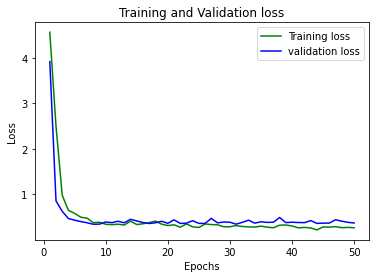

In [ ]:
import matplotlib.pyplot as plt
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1117    1
1119    1
1122    1
1129    3
1132    3
       ..
1382    1
1385    1
1404    3
1415    3
1416    1
Name: Reviewer-1, Length: 62, dtype: int64


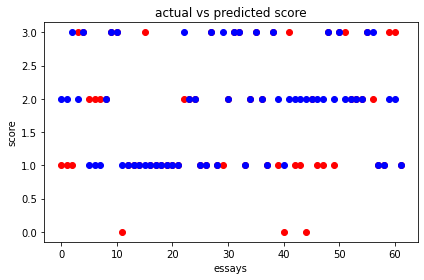

In [ ]:
print(y_test)
import matplotlib.pyplot as plt
x=np.arange(0,62)
plt.title("actual vs predicted score")
plt.xlabel("essays")
plt.ylabel("score")

plt.scatter(x,y_test.values,color='r',label="actual score")
plt.scatter(x,y_pred,color='b',label="predicted score")
plt.tight_layout()
plt.show()